In [1]:
from cil.utilities import dataexample, noise
import numpy as np
import matplotlib.pyplot as plt
import zarr
import pandas as pd
from matplotlib.lines import Line2D

# Get colors / markers / functions
colors = ("b", "g", "r", "c", "m", "y", "k")
markers = []
for m in Line2D.markers:
    try:
        if len(m) == 1 and m != " ":
            markers.append(m)
    except TypeError:
        pass

plt.rcParams['lines.linewidth'] = 5
plt.rcParams['lines.markersize'] = 20
plt.rcParams['font.size'] = 30

# util for timings
def pad_subarr_nan(list_of_arrays):
    max_len = max(arr.shape[0] for arr in list_of_arrays)
    padded_list = [np.pad(arr, (0, max_len - arr.shape[0]), constant_values=np.nan) for arr in list_of_arrays]
    return padded_list

### Load metadata for ProxSkip, FISTA, ISTA, PDHG, PDHGSkip

In [2]:
probs = [0.1, 0.3, 0.5, 0.7, 1.0]
warm_num = [10, 50, 100]

tmp_fista_time = {i:[] for i in warm_num}
tmp_proxskip_time = {i:{j:[] for j in probs} for i in warm_num}

tmp_fista_rse = {i:[] for i in warm_num}
tmp_proxskip_rse = {i:{j:[] for j in probs} for i in warm_num}

tmp_pdhgskip_time = {i:{j:[] for j in probs} for i in warm_num}
tmp_pdhgskip_rse = {i:{j:[] for j in probs} for i in warm_num}

tmp_pdhgskip_time_nowarm = {10:{1.0:[]}}
tmp_pdhgskip_rse_nowarm = {10:{1.0:[]}}

max_iterations = 4000
num_runs = 10
alpha = 0.1

fista_nrse = {i:None for i in warm_num}
proxskip_nrse = {i: {j:None for j in probs} for i in warm_num}

for warm in warm_num:

    for run in range(num_runs):
        
        res_fista = zarr.load("results/tomography_from_pdhg_explicit_precon_finden_runs_alpha_0.1/fista_step_size_7.5306420150791095e-06_run_{}_warm_{}.zarr".format(run, warm))
        tmp_fista_time[warm].append(res_fista["timing"])
        tmp_fista_rse[warm].append(res_fista["rse"])

for warm in warm_num:

    for prob in probs:

        for run in range(num_runs): 

            res_proxskip = zarr.load("results/tomography_from_pdhg_explicit_precon_finden_runs_alpha_0.1/proxskip_prob_{}_step_size_2.0x_run_{}_warm_{}.zarr".format(prob, run, warm))
            tmp_proxskip_time[warm][prob].append(res_proxskip["timing"]) 
            tmp_proxskip_rse[warm][prob].append(res_proxskip["rse"])

            res_pdhgskip = zarr.load("results/tomography_from_pdhg_explicit_precon_finden_runs_alpha_0.1/pdhgskip_prob_{}_step_size_0.08_run_{}_warm_{}.zarr".format(prob, run, warm))
            tmp_pdhgskip_time[warm][prob].append(res_pdhgskip["timing"]) 
            tmp_pdhgskip_rse[warm][prob].append(res_pdhgskip["rse"])


            if prob==1:
                if warm==10:
                    res_pdhgskip_nowarm = zarr.load("results/tomography_from_pdhg_explicit_precon_finden_runs_alpha_0.1/pdhgskip_prob_{}_step_size_0.08_run_{}_warm_{}.zarr".format(prob, run, warm))
                    tmp_pdhgskip_time_nowarm[warm][prob].append(res_pdhgskip_nowarm["timing"]) 
                    tmp_pdhgskip_rse_nowarm[warm][prob].append(res_pdhgskip_nowarm["rse"])

### Compute timing per iteration

In [3]:
for warm in warm_num:
    tmp_fista_time[warm] = pad_subarr_nan(tmp_fista_time[warm])
    tmp_fista_rse[warm] = pad_subarr_nan(tmp_fista_rse[warm])
    for prob in probs:
        tmp_proxskip_time[warm][prob] = pad_subarr_nan(tmp_proxskip_time[warm][prob])
        tmp_proxskip_rse[warm][prob] = pad_subarr_nan(tmp_proxskip_rse[warm][prob])
        tmp_pdhgskip_time[warm][prob] = pad_subarr_nan(tmp_pdhgskip_time[warm][prob])
        tmp_pdhgskip_rse[warm][prob] = pad_subarr_nan(tmp_pdhgskip_rse[warm][prob])        

fista_avg_time_per_iteration = {i:None for i in warm_num}
proxskip_avg_time_per_iteration = {i:{j:None for j in probs} for i in warm_num}
pdhgskip_avg_time_per_iteration = {i:{j:None for j in probs} for i in warm_num}
pdhgskip_std_time_per_iteration = {i:{j:None for j in probs} for i in warm_num}

# no warm
pdhgskip_avg_time_per_iteration_nowarm = {10:{1.0:None}}
pdhgskip_std_time_per_iteration_nowarm = {10:{1.0:None}}


for warm in warm_num:
    fista_avg_time_per_iteration[warm] = np.nanmean(tmp_fista_time[warm], axis=0)

    for prob in probs:
        proxskip_avg_time_per_iteration[warm][prob] = np.nanmean(tmp_proxskip_time[warm][prob], axis=0)
        pdhgskip_avg_time_per_iteration[warm][prob] = np.nanmean(tmp_pdhgskip_time[warm][prob], axis=0)

        pdhgskip_std_time_per_iteration[warm][prob] = np.nanstd(tmp_pdhgskip_time[warm][prob], axis=0)

        if prob==1.0:
            if warm==10:
                pdhgskip_avg_time_per_iteration_nowarm[warm][prob] = np.nanmean(tmp_pdhgskip_time_nowarm[warm][prob], axis=0)
                pdhgskip_std_time_per_iteration_nowarm[warm][prob] = np.nanstd(tmp_pdhgskip_time_nowarm[warm][prob], axis=0)

fista_time_per_run = {i:None for i in warm_num}
proxskip_time_per_run = {i:{j:None for j in probs} for i in warm_num}
pdhgskip_time_per_run = {i:{j:None for j in probs} for i in warm_num}

pdhgskip_time_per_run_nowarm = {10:{1.0:None }}

for warm in warm_num:
    fista_time_per_run[warm] = np.nansum(tmp_fista_time[warm], axis=1)

    for prob in probs:
        proxskip_time_per_run[warm][prob] = np.nansum(tmp_proxskip_time[warm][prob], axis=1)
        pdhgskip_time_per_run[warm][prob] = np.nansum(tmp_pdhgskip_time[warm][prob], axis=1)

        if prob==1.0:
            if warm==10:
                pdhgskip_time_per_run_nowarm[warm][prob] = np.nansum(tmp_pdhgskip_time_nowarm[warm][prob], axis=1)


fista_avg_rse_per_iteration = {i:None for i in warm_num}
proxskip_avg_rse_per_iteration = {i:{j:None for j in probs} for i in warm_num}
pdhgskip_avg_rse_per_iteration = {i:{j:None for j in probs} for i in warm_num}
pdhgskip_avg_rse_per_iteration_nowarm = {10:{1.0:None}}


for warm in warm_num:
    fista_avg_rse_per_iteration[warm] = np.nanmean(tmp_fista_rse[warm], axis=0)

    for prob in probs:
        proxskip_avg_rse_per_iteration[warm][prob] = np.nanmean(tmp_proxskip_rse[warm][prob], axis=0)
        pdhgskip_avg_rse_per_iteration[warm][prob] = np.nanmean(tmp_pdhgskip_rse[warm][prob], axis=0)

        if warm==10:
            if prob==1.0:
                pdhgskip_avg_rse_per_iteration_nowarm[warm][prob] = np.nanmean(tmp_pdhgskip_rse_nowarm[warm][prob], axis=0)


In [4]:

colors = ['steelblue', 'red', 'orange', 'brown', 'green']
markevery = 100
                 

### Plots for Proximal Gradient Algos

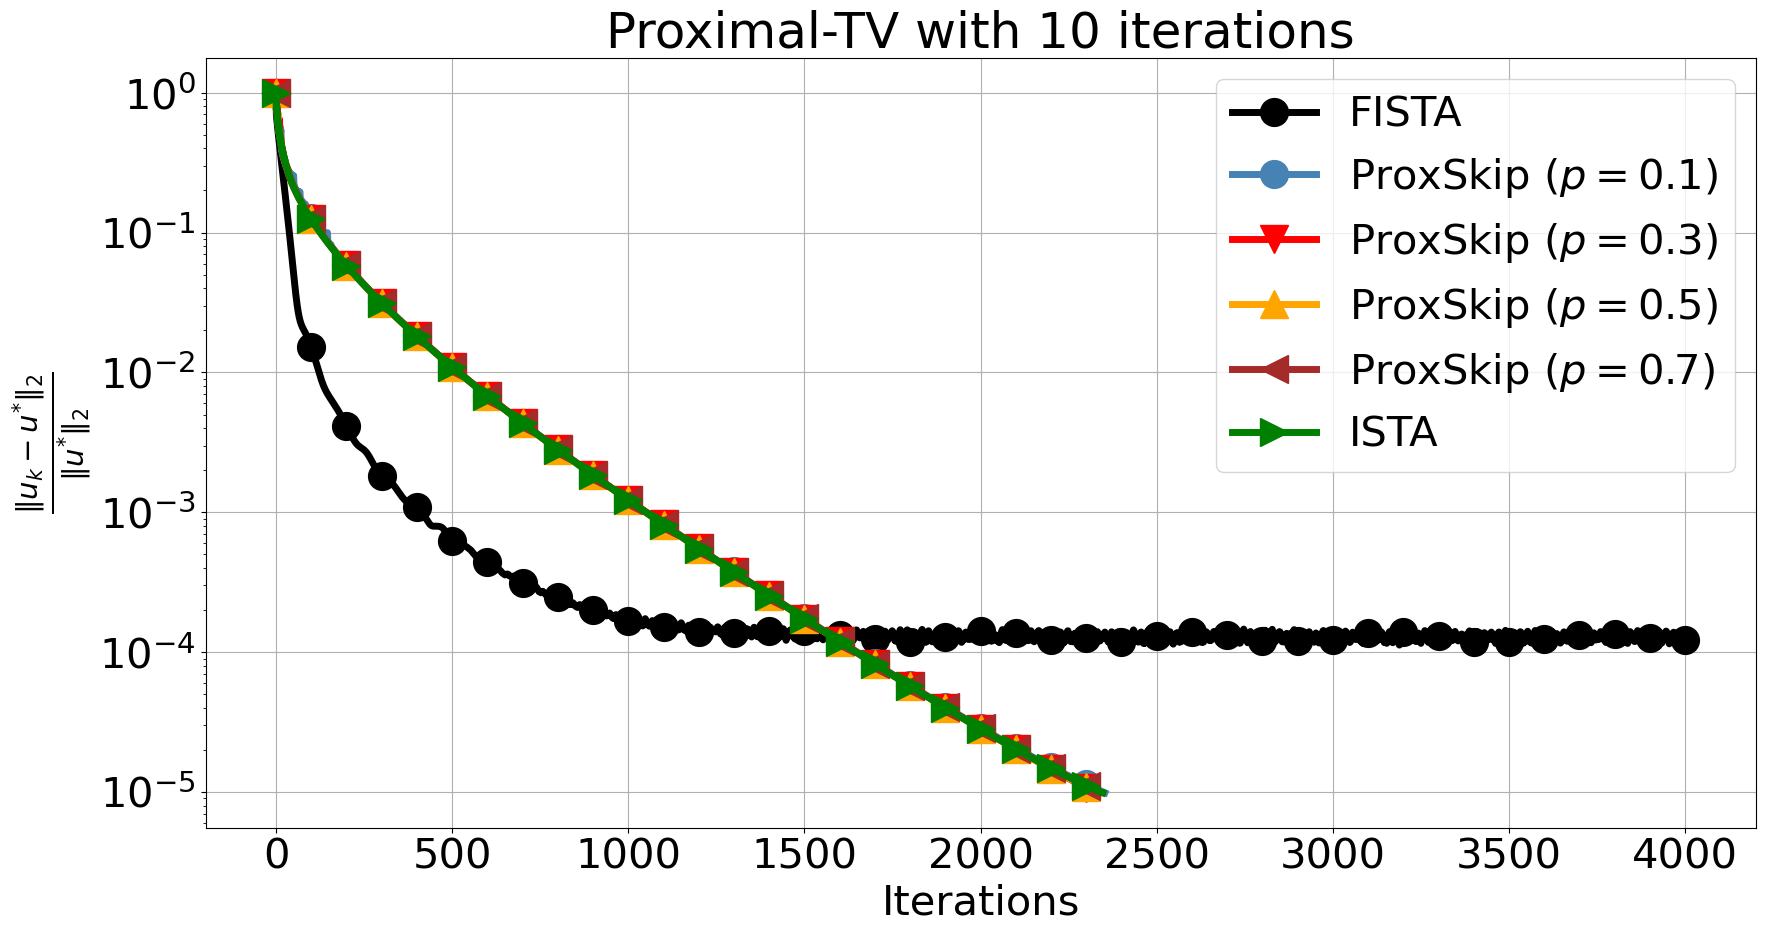

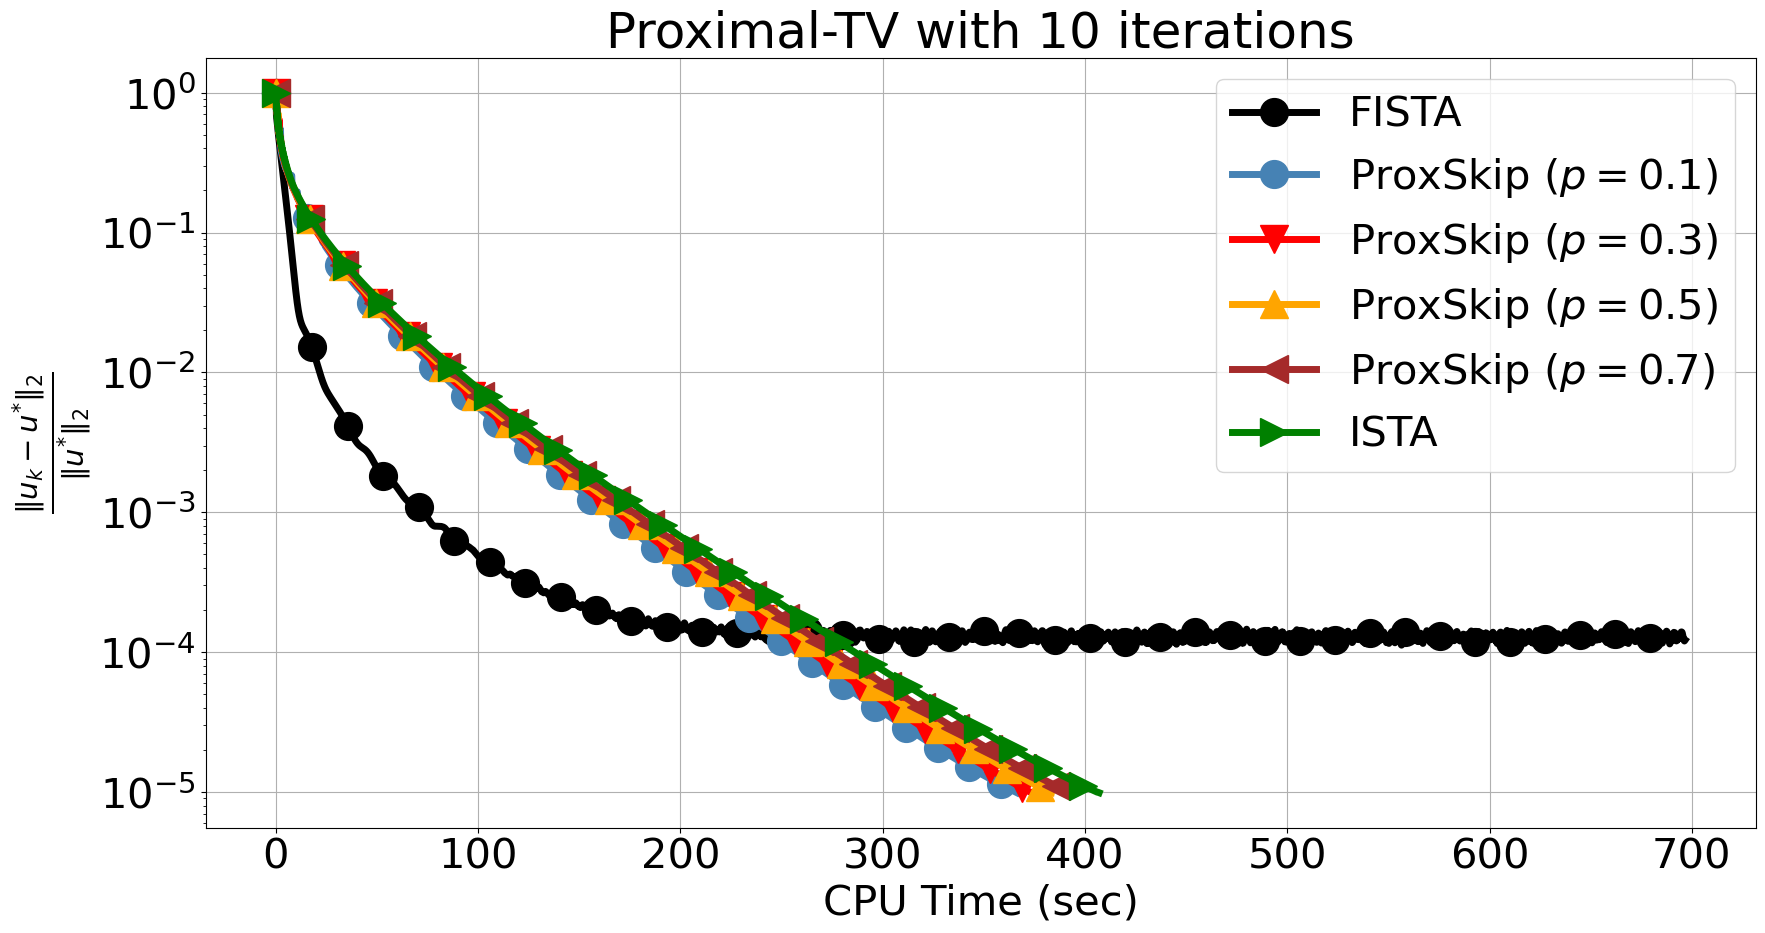

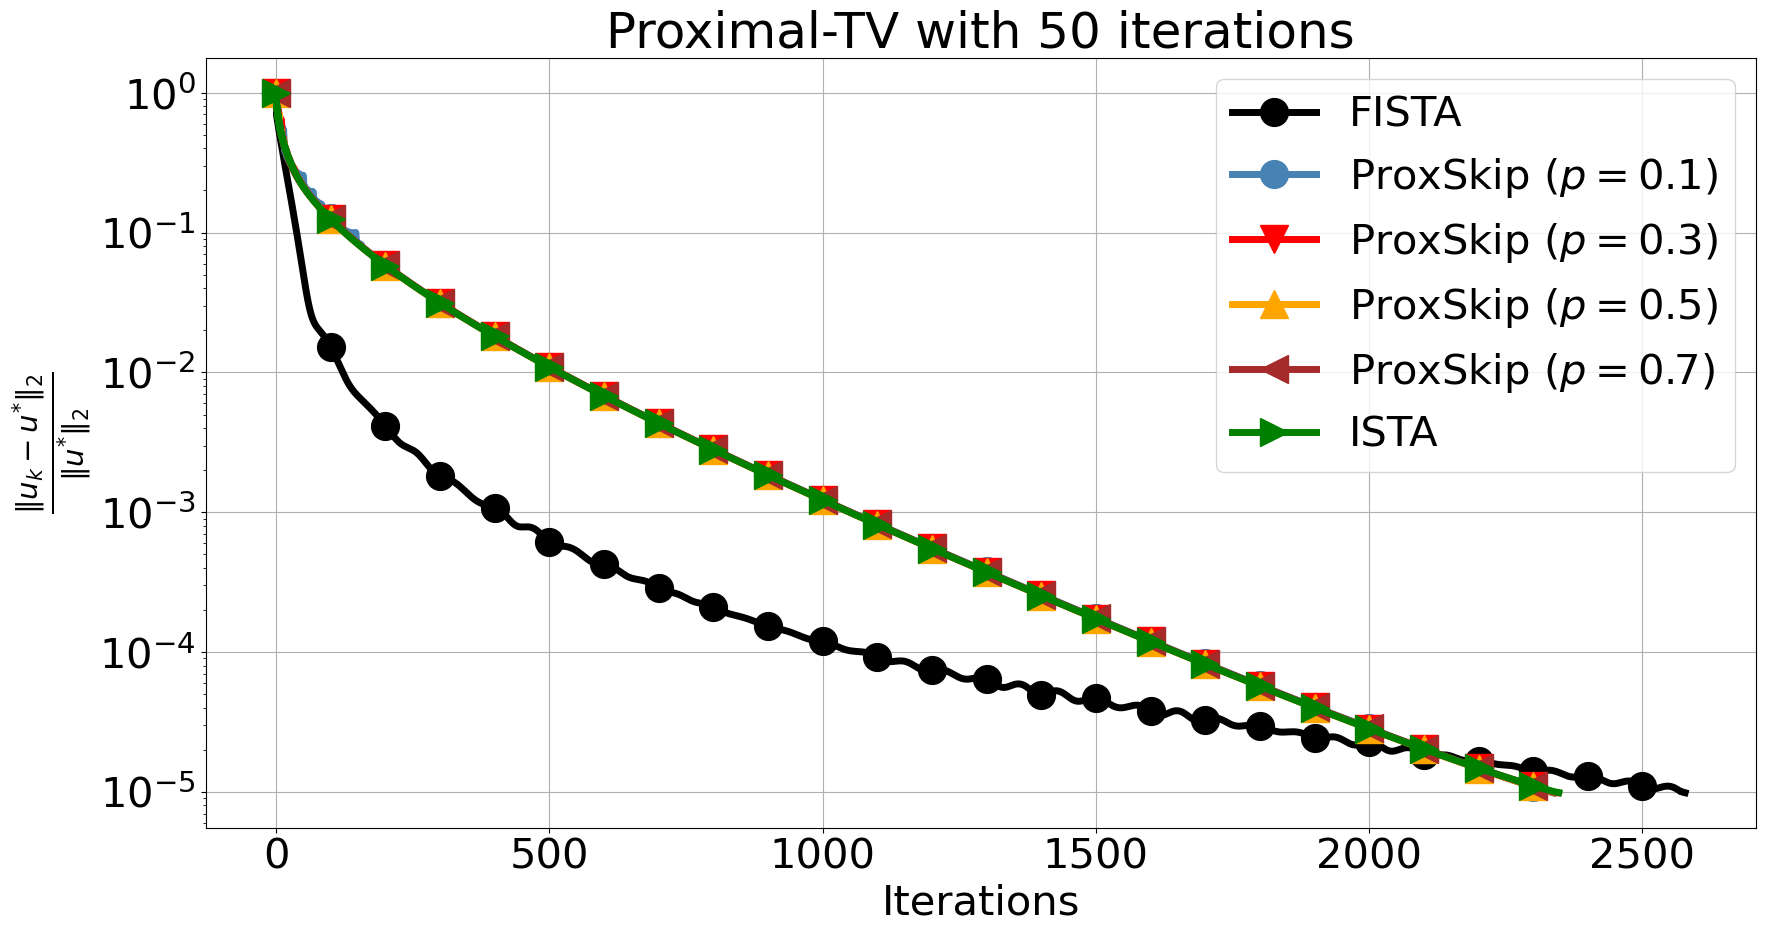

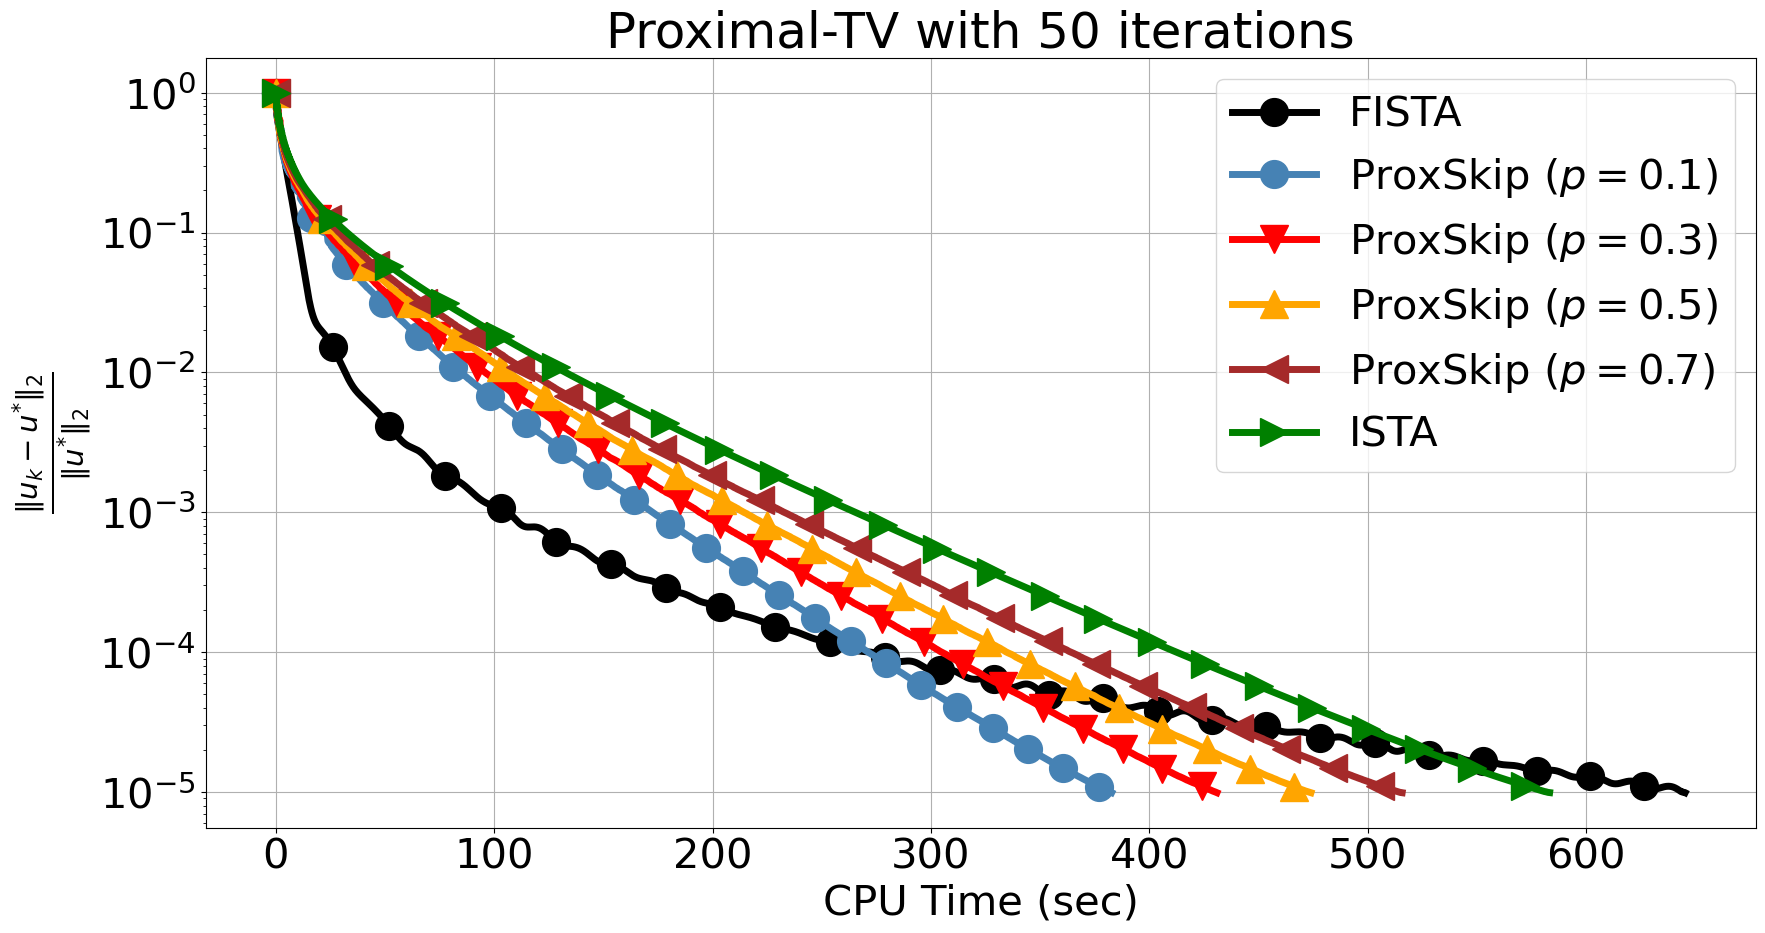

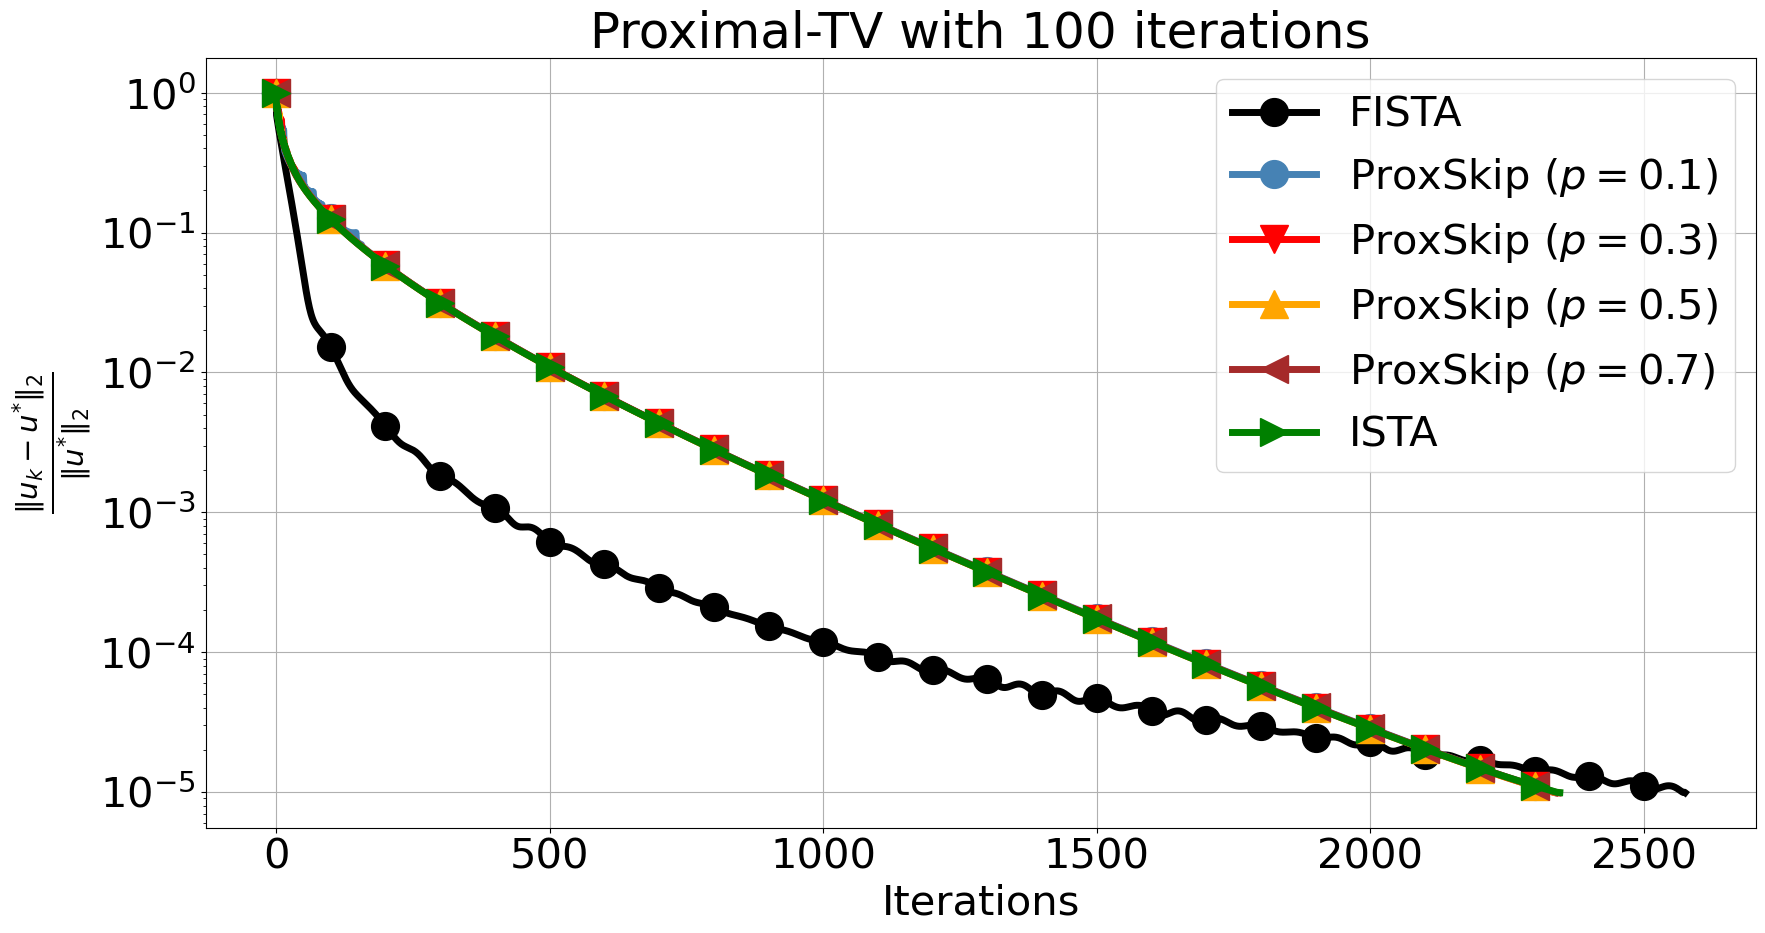

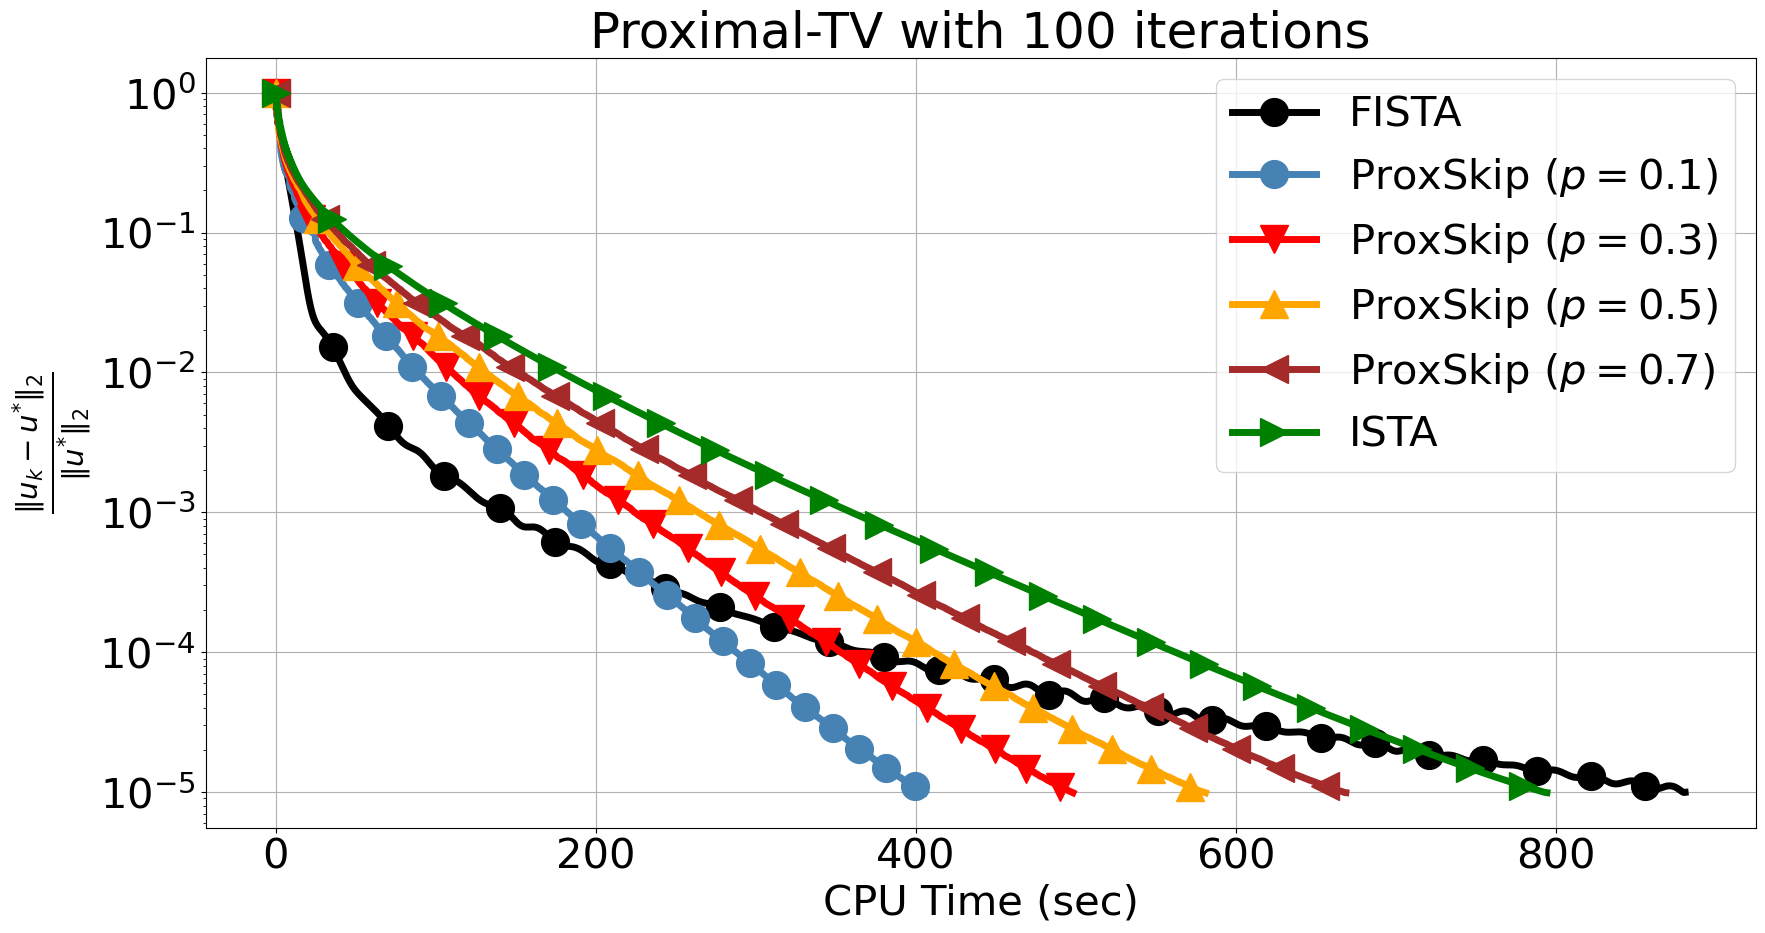

In [5]:
for case in warm_num:

    fig, ax = plt.subplots(figsize=(20,10))
    
    ax.semilogy(fista_avg_rse_per_iteration[case], label="FISTA", markevery=markevery, marker=markers[2], color="black")
    for i in range(len(probs)):
        if probs[i]==1.0:
            # pass
            ax.semilogy(proxskip_avg_rse_per_iteration[case][probs[i]], label=r"ISTA",  
                    markevery=markevery, color=colors[i], marker = markers[i+2])
        else:
            ax.semilogy(proxskip_avg_rse_per_iteration[case][probs[i]], label=r"ProxSkip ($p={}$)".format(probs[i]),  
                    markevery=markevery, color=colors[i], marker = markers[i+2])

    ax.legend()
    ax.grid(which="major")
    plt.ylabel(r"$\frac{\|u_{k} - u^{*}\|_{2}}{\|u^{*}\|_{2}}$")
    plt.xlabel("Iterations")
    plt.title("Proximal-TV with {} iterations".format(case))
    # plt.savefig("figures/tomography/ista_fista_proxskip_{}_warm_alpha_{}_iterates_xaxis_iterations_pdhg_precond.png".format(case, alpha), bbox_inches='tight')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20,10))
    
    ax.semilogy(np.cumsum(fista_avg_time_per_iteration[case]), fista_avg_rse_per_iteration[case][:-1], label="FISTA", markevery=markevery, marker=markers[2], color="black")
    for i in range(len(probs)):
        if probs[i]==1.0:
            # pass
            ax.semilogy(np.cumsum(proxskip_avg_time_per_iteration[case][probs[i]]), 
                    proxskip_avg_rse_per_iteration[case][probs[i]][:-1], label="ISTA",  
                    markevery=markevery, color=colors[i], marker = markers[i+2])      
        else:
            ax.semilogy(np.cumsum(proxskip_avg_time_per_iteration[case][probs[i]]), 
                    proxskip_avg_rse_per_iteration[case][probs[i]][:-1], label=r"ProxSkip ($p={}$)".format(probs[i]),  
                    markevery=markevery, color=colors[i], marker = markers[i+2])
    # ax.legend(bbox_to_anchor=(1.01, 1.01))
    ax.legend()
    ax.grid(which="major")
    plt.ylabel(r"$\frac{\|u_{k} - u^{*}\|_{2}}{\|u^{*}\|_{2}}$")
    plt.xlabel('CPU Time (sec)')
    plt.title("Proximal-TV with {} iterations".format(case))
    # plt.xlim(450,500)
    # plt.savefig("figures/tomography/ista_fista_proxskip_{}_warm_alpha_{}_iterates_xaxis_time_pdhg_precond.png".format(case, alpha), bbox_inches='tight')
    plt.show()

### Plots for Primal-dual

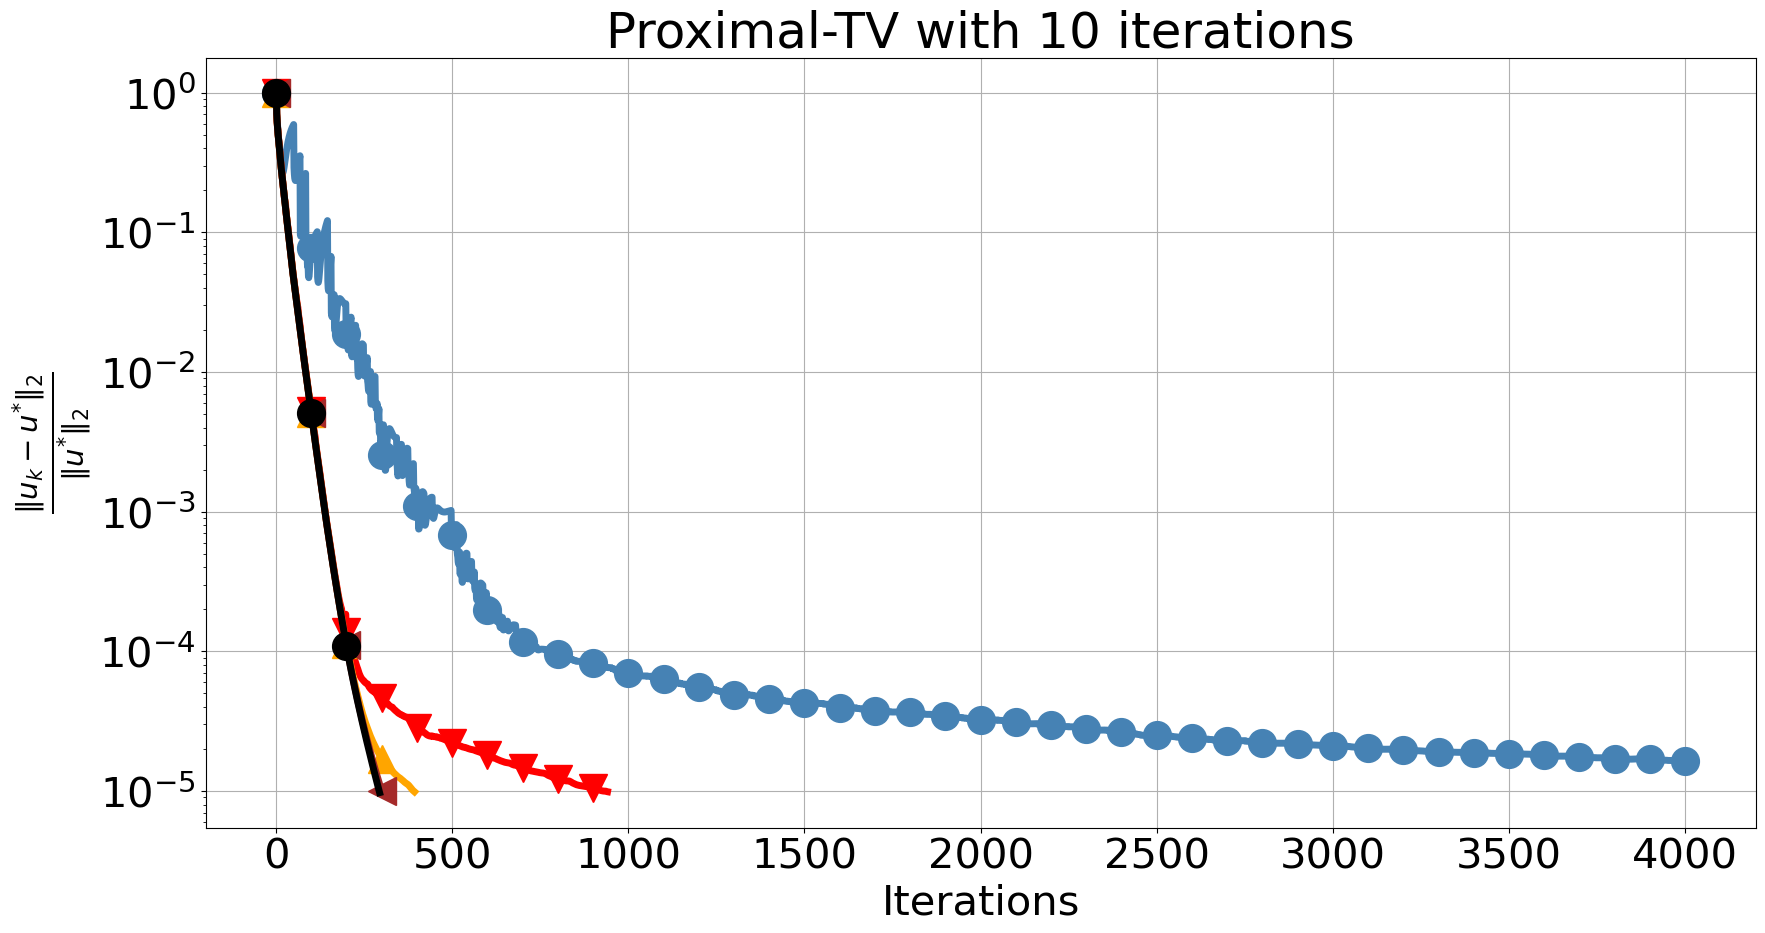

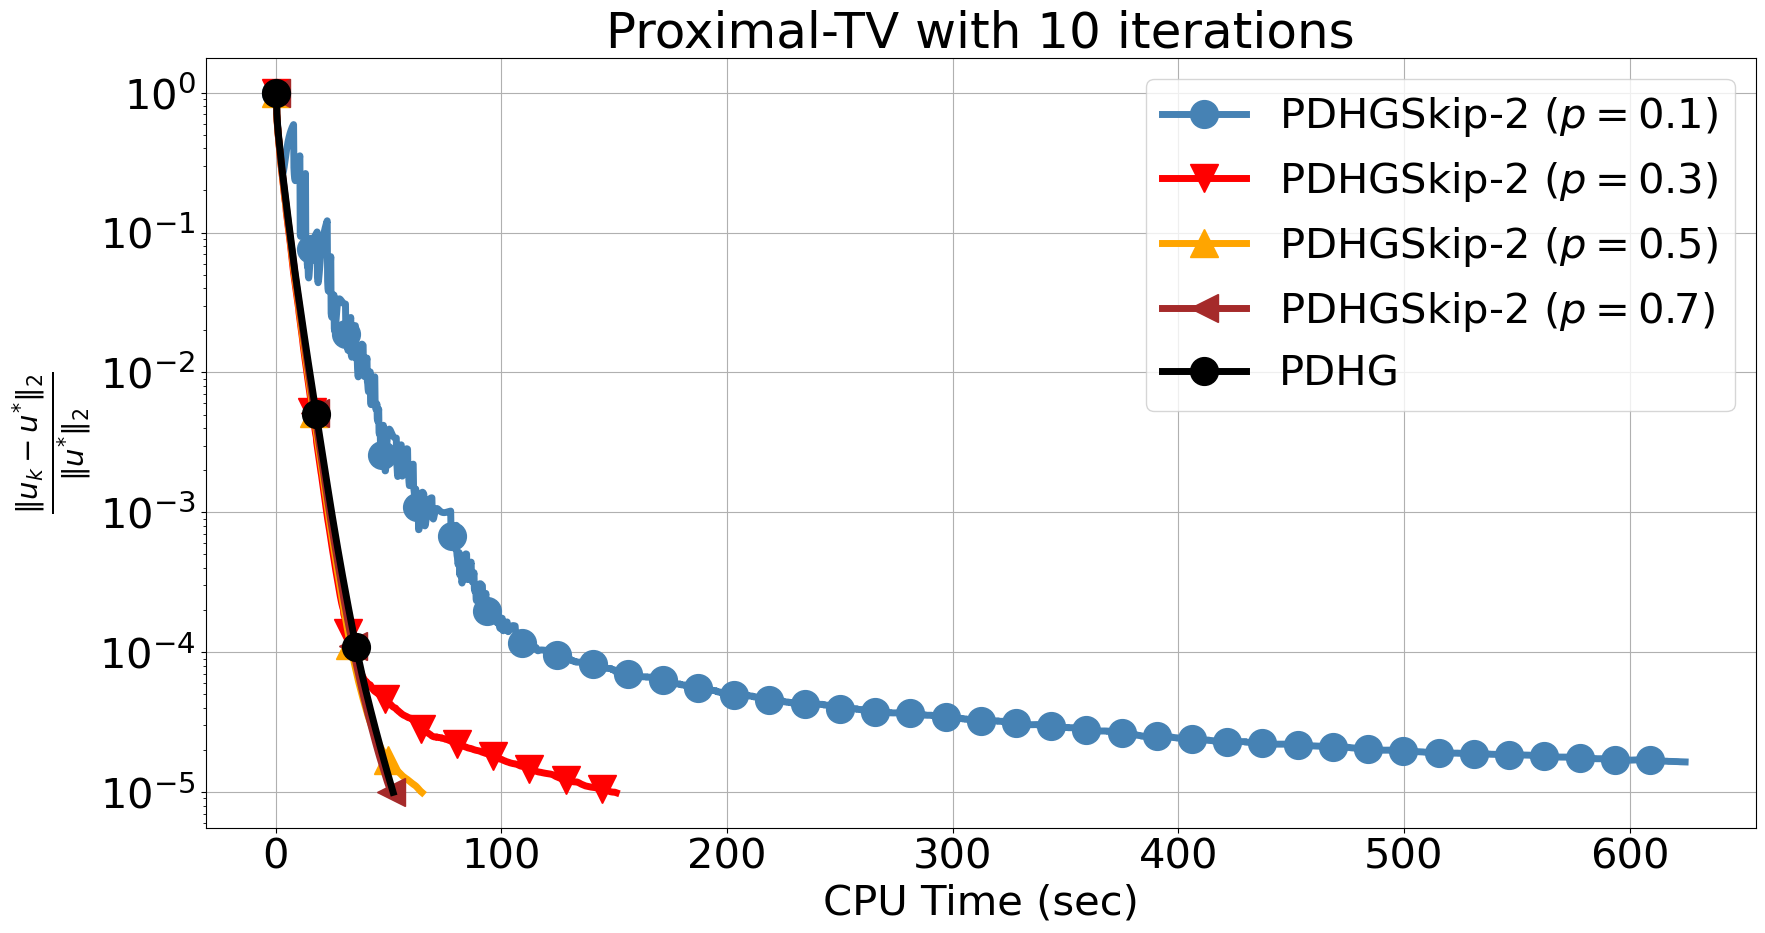

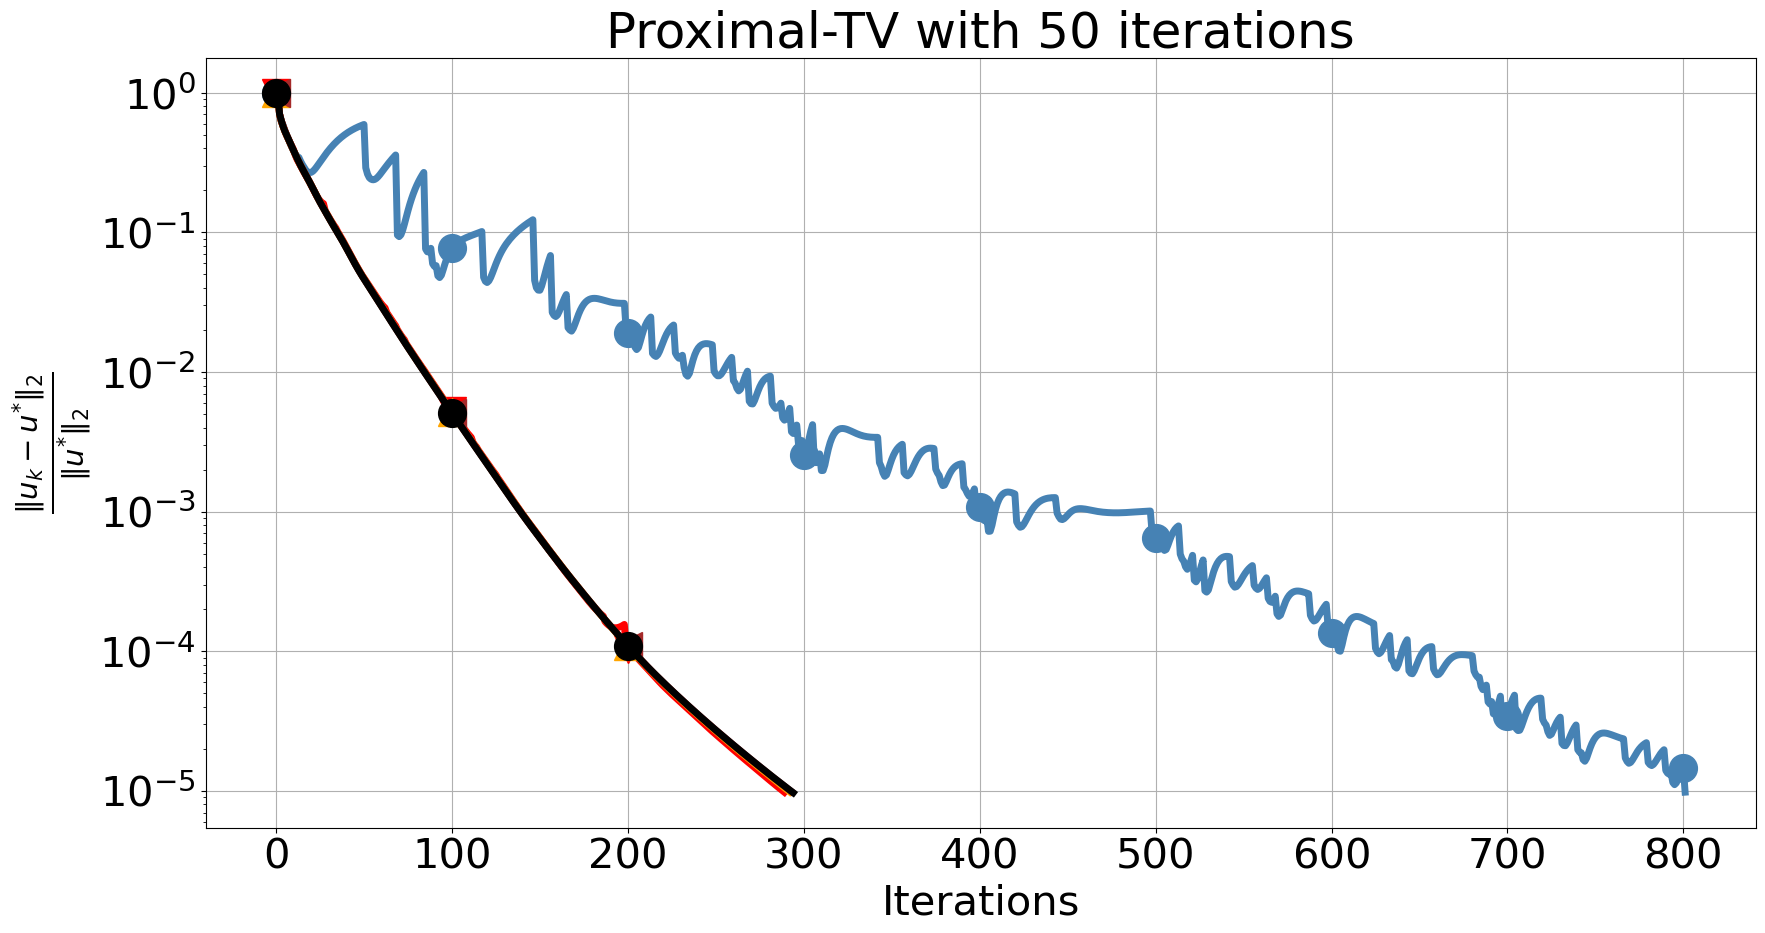

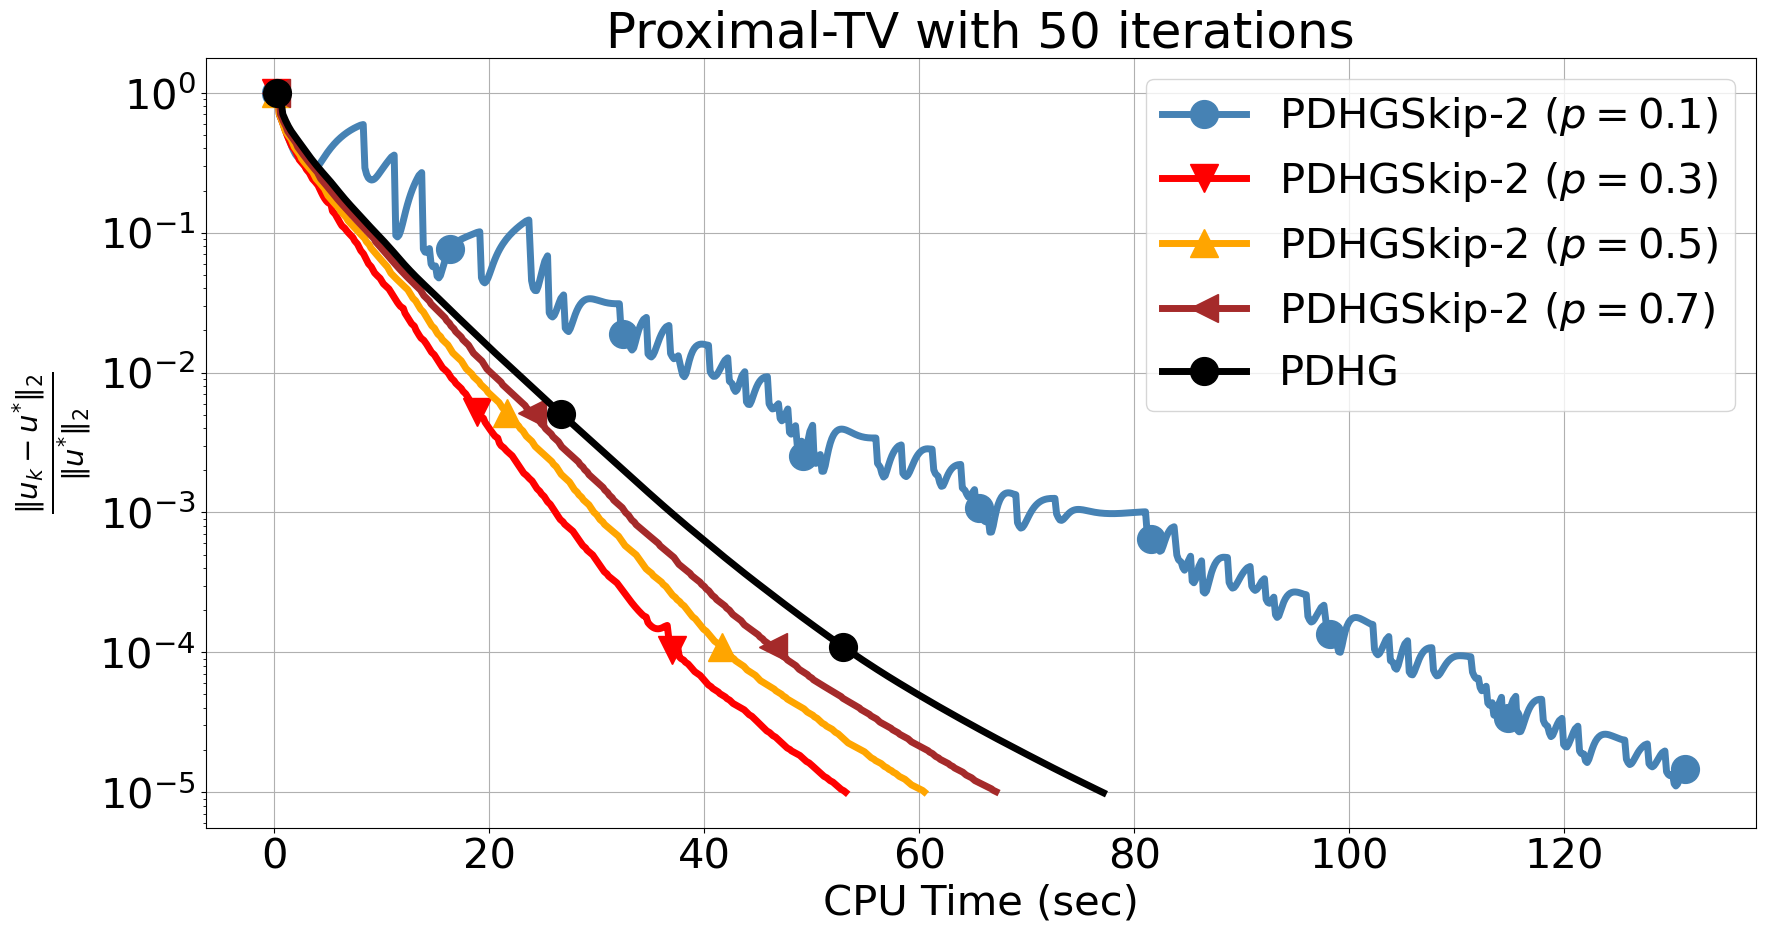

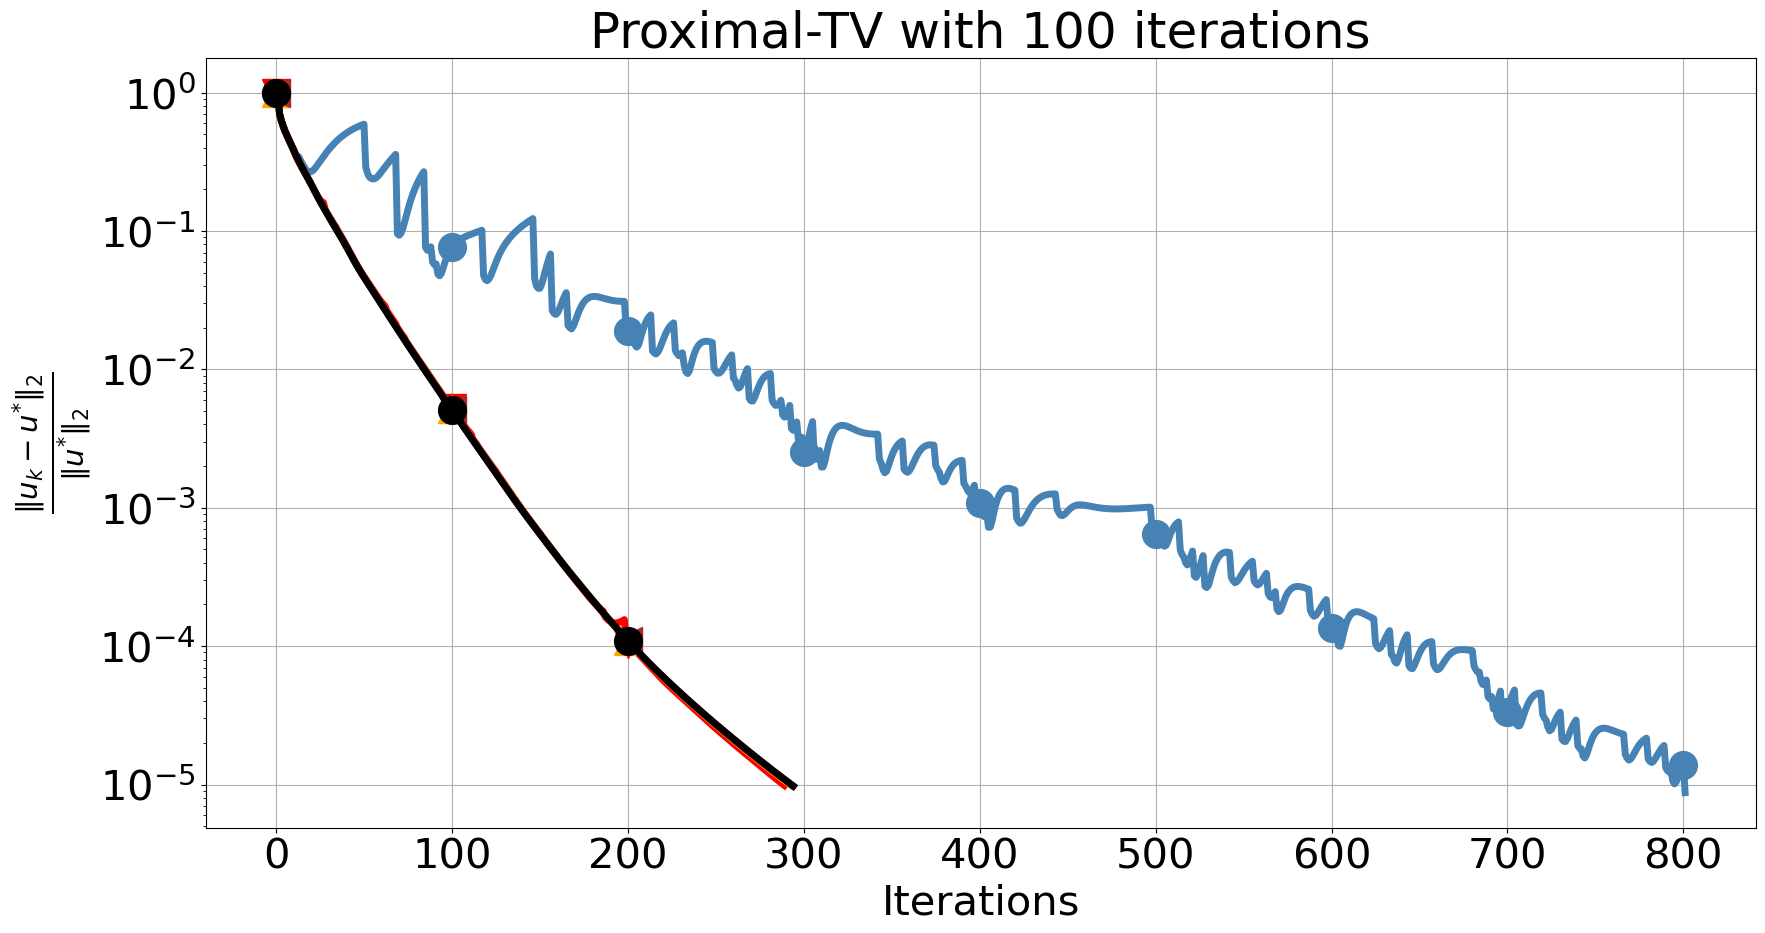

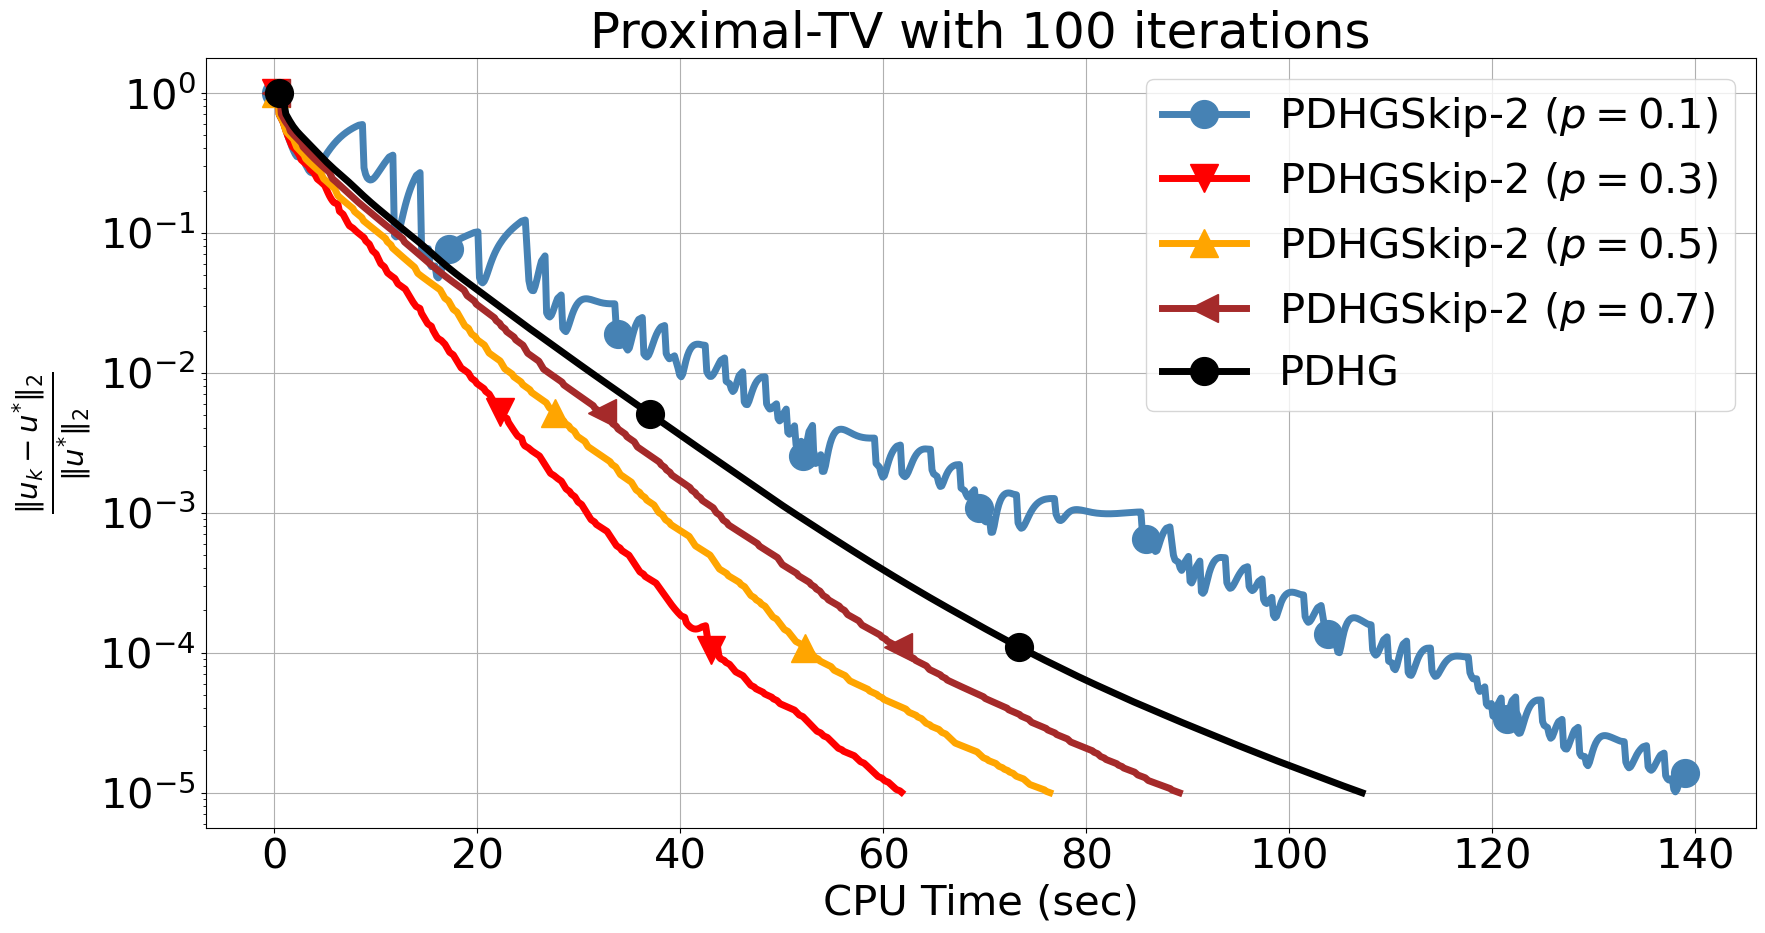

In [6]:
for case in warm_num:

    fig, ax = plt.subplots(figsize=(20,10))
    
    for i in range(len(probs)):
        if probs[i]==1.0:
            ax.semilogy(pdhgskip_avg_rse_per_iteration[case][probs[i]], label="PDHG",  
                        markevery=markevery, color="black", marker = markers[2])
        else:
            ax.semilogy(pdhgskip_avg_rse_per_iteration[case][probs[i]], label=r"PDHGSkip ($p={}$)".format(probs[i]),  
                        markevery=markevery, color=colors[i], marker = markers[i+2])            

    # ax.legend()
    ax.grid(which="major")
    plt.ylabel(r"$\frac{\|u_{k} - u^{*}\|_{2}}{\|u^{*}\|_{2}}$")
    plt.xlabel("Iterations")
    plt.title("Proximal-TV with {} iterations".format(case))
    # plt.savefig("figures/tomography/pdhg_pdhgskip_{}_warm_alpha_{}_iterates_xaxis_iterations.png".format(case, alpha), bbox_inches='tight')
    plt.show()


    
    fig, ax = plt.subplots(figsize=(20,10))
    
    # ax.semilogy(np.cumsum(fista_avg_time_per_iteration[case]), fista_avg_rse_per_iteration[case][:-1], label="FISTA", markevery=markevery, marker=markers[2], color="black")
    for i in range(len(probs)):
        if probs[i]==1.0:
            ax.semilogy(np.cumsum(pdhgskip_avg_time_per_iteration[case][probs[i]]), 
                        pdhgskip_avg_rse_per_iteration[case][probs[i]][:-1], label=r"PDHG".format(probs[i]),  
                        markevery=markevery, color="black", marker = markers[2]) 
        else:
            ax.semilogy(np.cumsum(pdhgskip_avg_time_per_iteration[case][probs[i]]), 
                    pdhgskip_avg_rse_per_iteration[case][probs[i]][:-1], label=r"PDHGSkip-2 ($p={}$)".format(probs[i]),  
                    markevery=markevery, color=colors[i], marker = markers[i+2])
    # ax.legend(bbox_to_anchor=(1.01, 1.01))
    ax.legend()
    ax.grid(which="major")
    plt.ylabel(r"$\frac{\|u_{k} - u^{*}\|_{2}}{\|u^{*}\|_{2}}$")
    plt.xlabel('CPU Time (sec)')
    plt.title("Proximal-TV with {} iterations".format(case))
    # plt.savefig("figures/tomography/pdhg_pdhgskip_{}_warm_alpha_{}_iterates_xaxis_time.png".format(case, alpha), bbox_inches='tight')
    plt.show()